# Importing Libraries

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Useful Functions

In [2]:
def plot_time_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)


def trend(time, slope=0):
    return slope * time


def seasonal_pattern(season_time):
  return np.where(season_time < 0.4,
                  np.cos(season_time * 2 * np.pi),
                  1 / np.exp(3 * season_time))
  

def seasonality(time, period, amplitude=1, phase=0):
  season_time = ((time + phase) % period) / period
  return amplitude * seasonal_pattern(season_time)


def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

# Create Time Series

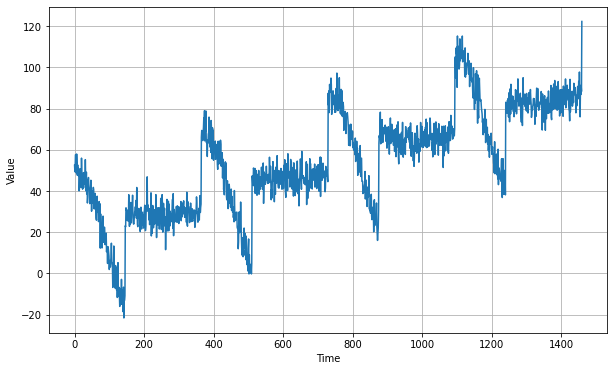

In [3]:
time = np.arange(4 * 365 + 1, dtype="float32")

baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5
period = 365

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=period, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

plt.figure(figsize=(10, 6))
plot_time_series(time, series)
plt.show()

# Splitting Time Series

In [4]:
split_time = 1000

time_train = time[:split_time]
x_train = series[:split_time]

time_valid = time[split_time:]
x_valid = series[split_time:]

# Creating windowed dataset

In [5]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [6]:
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [7]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(dataset)

for x,y in dataset:
  print(x.numpy(), y.numpy())
  break

<PrefetchDataset shapes: ((None, None), (None,)), types: (tf.float32, tf.float32)>
[[ 56.963406    53.19721     66.379585    61.65801     59.0514
   67.68912     65.35661     61.307972    57.718082    68.47362
   67.35454     63.60032     73.322525    58.73252     56.449394
   60.612007    63.838596    65.278656    62.85165     65.81443   ]
 [ 67.919136    68.053764    66.2601      59.30633     63.911392
   64.14101     58.376602    71.69516     68.57505     63.09382
   64.34379     65.262314    54.023083    63.007553    60.845512
   59.259632    62.87484     73.28169     67.5107      61.464104  ]
 [ 28.541082    28.048655    22.028439    29.518435    30.52015
   33.118732    32.960247    20.791162    22.97916     30.232738
   30.216269    30.212847    46.89202     30.474054    33.289154
   32.373535    30.853155    26.012995    31.377792    23.712889  ]
 [ 45.461845    53.09068     41.916256    50.42897     50.342705
   45.857548    49.064213    41.20642     52.11075     46.594894
   

# Create Model

In [8]:
l0 = tf.keras.layers.Dense(1, input_shape=[window_size])
model = tf.keras.models.Sequential([
  l0
])

model.compile(
  loss = 'mse',
  optimizer = tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9)
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 21        
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


In [9]:
model.fit(dataset,
          epochs=100)

Epoch 1/100
31/31 [==============================] - 1s 2ms/step - loss: 302.6176
Epoch 2/100
31/31 [==============================] - 0s 2ms/step - loss: 98.1526
Epoch 3/100
31/31 [==============================] - 0s 1ms/step - loss: 83.6162
Epoch 4/100
31/31 [==============================] - 0s 2ms/step - loss: 81.3249
Epoch 5/100
31/31 [==============================] - 0s 2ms/step - loss: 79.3017
Epoch 6/100
31/31 [==============================] - 0s 1ms/step - loss: 76.8268
Epoch 7/100
31/31 [==============================] - 0s 1ms/step - loss: 77.0749
Epoch 8/100
31/31 [==============================] - 0s 1ms/step - loss: 73.7989
Epoch 9/100
31/31 [==============================] - 0s 1ms/step - loss: 72.6040
Epoch 10/100
31/31 [==============================] - 0s 2ms/step - loss: 71.7150
Epoch 11/100
31/31 [==============================] - 0s 1ms/step - loss: 68.8774
Epoch 12/100
31/31 [==============================] - 0s 2ms/step - loss: 68.6285
Epoch 13/100
31/31 [====

In [10]:
print("Layer weights {}".format(l0.get_weights()))

Layer weights [array([[ 4.08880375e-02],
       [-2.60347351e-02],
       [-4.20333333e-02],
       [-6.32594302e-02],
       [ 9.93853211e-02],
       [ 4.97684535e-03],
       [-3.98097076e-02],
       [ 1.89874228e-02],
       [ 2.51163766e-02],
       [-1.39724715e-02],
       [ 1.98115148e-02],
       [-3.85933071e-02],
       [-6.50012121e-02],
       [ 1.00070402e-01],
       [ 3.19875665e-02],
       [-3.92034417e-04],
       [ 5.23569956e-02],
       [ 1.70946568e-01],
       [ 2.44004101e-01],
       [ 4.71892059e-01]], dtype=float32), array([0.01243297], dtype=float32)]


In [12]:
forecast = []

for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


print(len(results))

461


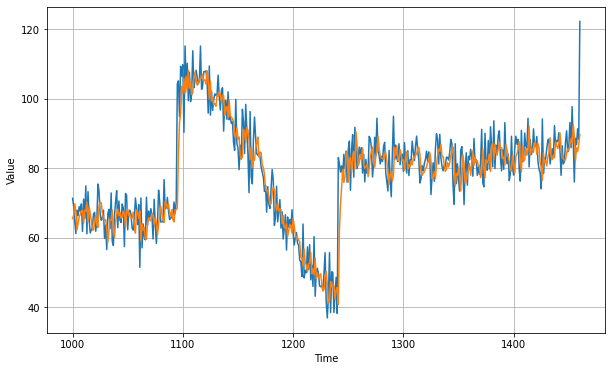

In [13]:
plt.figure(figsize=(10, 6))

plot_time_series(time_valid, x_valid)
plot_time_series(time_valid, results)

In [14]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

4.952662